# An algorithm for simulating karst conduit evolution in anisotropic, heterogeneous, and discontinuous settings #
### Supplementary material: code to generate the examples and figures presented in the paper ###
**Authors:** Chloé Fandel, Ty Ferré , François Miville, Philippe Renard. 2020. <br>

**Abstract:** Anisotropic fast marching algorithms are a computationally efficient tool for generating realistic karst conduit networks constrained by both the spatial extent and the orientation of karstifiable geologic units. Existing conduit evolution models are limited either by high computational requirements (for chemistry-based models) or by their inability to account for the effects of elevation and orientation gradients (for isotropic fast marching models). The new anisotropic fast marching approach described here provides a significant improvement, particularly for the purposes of rapidly generating a stochastic ensemble of plausible networks from basic geologic information and/or for generating networks that can be used in groundwater flow models such as SWMM of MODFLOW-CFP. We provide an open-source, easy-to-use implementation of the anisotropic fast marching algorithm for the purpose of karst conduit network modeling through integration with the existing Python package pyKasso.

**Note:** Because this model has a stochastic element, each run is likely to be slightly different. The figures in this notebook will therefore not exactly match the published figures.

TO-DO:
- [ ] remove little blips?
- [ ] calculate orientations from scalar map csv
- [ ] add a grid function to convert indices to coordinates and vice-versa (use same as hfm built-in?)

### Setup & imports ###
For development, import a local version of pykasso be able to make and test changes.
Use one of the two methods below (but not both).


In [330]:
method = 2

#Method 1: using importlib
if method==1:
    import importlib.util
    spec = importlib.util.spec_from_file_location('pykasso', 'C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso/base.py')
    pk = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(pk)

#Method 2: setting the path variable to the path to the local version 
#This version allows reloading the module to see changes
if method==2:
    import sys
    sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
    import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #uncomment this line to create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [2]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import copy
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import karstnet as kn

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann

#Local modules:
import importlib.util
spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/Chloe/Documents/GitHub/gottesacker/swmmpy.py')
sp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sp)

os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

## Simple one-valley system ###
A simple synthetic system, consisting of a single outlet draining a valley. There are only three geologic units: highly karstifiable limestone folded into a syncline along the valley axis, underlain by non-karstifiable shale, with an obstacle in the form of a non-karstifiable granite intrusion. Five inlets are randomly distributed across the upper part of the valley. 

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


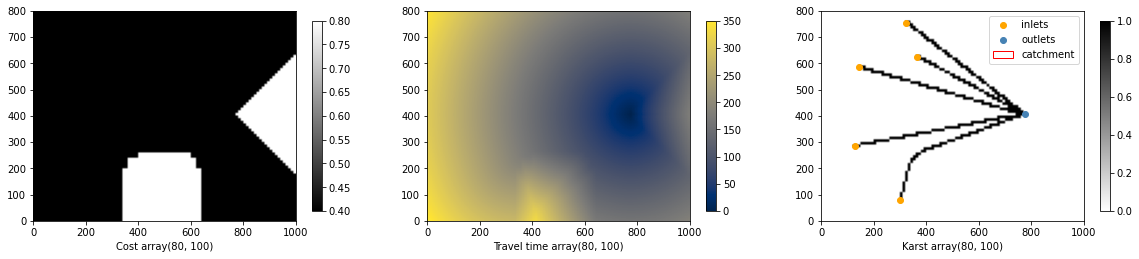

- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


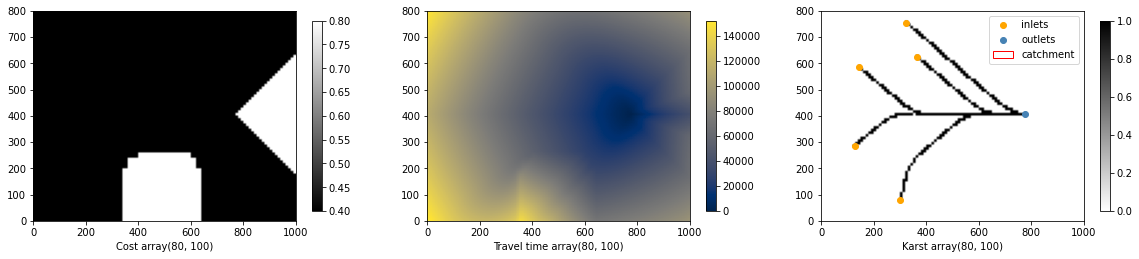

In [335]:
importlib.reload(pk)

#Load model:
catchment = pk.SKS('inputs/valley1/settings.yaml') 

#Modify model settings (uncomment to activate):
#catchment.set_fractures_mode('random')                          #randomly generate a discrete fracture network
#catchment.update_fractures()                                    #when altering the model's geologic setting, update after making changes
#catchment.set_inlets_importance([1,2,2])                        #assign the first inlet to the first iteration, the next two to the second iteration, and the next two to the last iteration
#catchment.set_outlets_data('inputs/valley1/outlets2D.txt')      #load a new outlet file with two outlets instead of one
#catchment.update_outlets()                                      #update
#catchment.set_outlets_importance([1,1])                         #assign one outlet to the first iteration and one to the second iteration
#catchment.set_inlets_per_outlet([2,3])                          #assign the first two inlets to the first outlet, and the remaining three inlets to the second outlet
#catchment.set_inlets_importance([1])                            #assign all inlets for each outlet to a single iteration
catchment.set_orientation_mode('surface')                        #use the lower surface of the karst unit as the anisotropy field
catchment.update_orientation()                                   #update

#Run isotropic conduit network simulation & display results:
catchment.compute_karst_network()
catchment.show()
#catchment.show_network(data=catchment.karst_simulations[0], simplify=False, labels=['inlets','outlets'], plot_nodes=False, legend=False, color='k')

#Run anisotropic conduit network simulation & display results:
catchment.set_algorithm('Riemann2')
catchment.compute_karst_network()
catchment.show()

#### Expected behavior ####
In this example, we would expect conduits to travel towards and along the synclinal axis before reaching the outlet. However, the isotropic fast marching algorithm returns conduits that instead follow the most direct path to the outlet as the crow flies. 

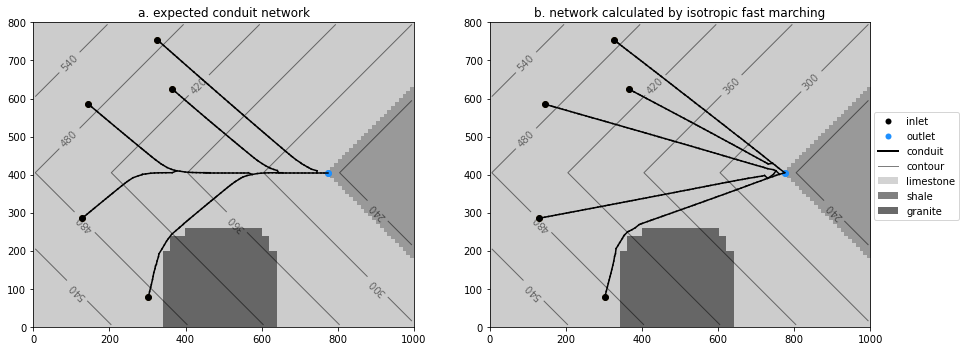

In [336]:
#Plot anisotropic vs. isotropic with no fractures and no iteration

###########################
#Set up a figure, and a colormap to plot fractures and conduits with a transparent background
f = plt.figure(figsize=(15,15))
cmap = matplotlib.colors.ListedColormap(['whitesmoke'])   #fractures will be off-white
cmap.set_under(color='w', alpha=0)                        #all values under range will be transparent
cmap2 = matplotlib.colors.ListedColormap(['k'])           #conduits will be black
cmap2.set_under(color='w', alpha=0)                       #all values under range will be transparent
frac = catchment.geology.data['fractures']['data'].copy() #get a copy of the fractures array
frac[frac<1] = -1                                         #replace all non-fracture cells with an out of bounds value to make them transparent

###############
ax = f.add_subplot(121, aspect='equal')
ax.set_title('a. expected conduit network')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)

catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

###################
ax = f.add_subplot(122, aspect='equal')
ax.set_title('b. network calculated by isotropic fast marching')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)

catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

###############
legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=2, alpha=1,   label='conduit'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          #matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.35])

#### Step-by-step walk-through of pyKasso's functioning ###

Inputs:
- geologic model indicating which lithologic unit is present in each cell
- coordinates of the known inlets and outlets to the system
- scalar potential array to be used for calculating the anisotropy field
- statistics describing the fracture network
- relative travel costs associated with different geologic features
- cost ratio to calculate the travel cost perpendicular to the gradient

Steps:
- discrete fracture network 
- cost map 
- vector field describing the anisotropy of the system 

Iteration:<br>
Although the entire conduit network could be simulated in a single iteration, if a realistic hierarchical structure is desired, if certain inlets are known to be connected to specific outlets, or if the purpose of the modeling is to reconstruct the phases of paleokarst evolution, it is preferable to iterate over several phases of conduit formation, updating the travel cost map and travel time map at each step. 

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 Network statistics:


{'mean length': 177.04453525258853,
 'cv length': 0.8386329139626042,
 'length entropy': 0.7448869593860206,
 'tortuosity': 1.022278425717592,
 'orientation entropy': 0.8863596032019492,
 'aspl': 3.1794871794871797,
 'cpd': 0.5239898989898989,
 'mean degree': 2.0,
 'cv degree': 0.4803844614152614,
 'correlation vertex degree': -0.4083333333333335}

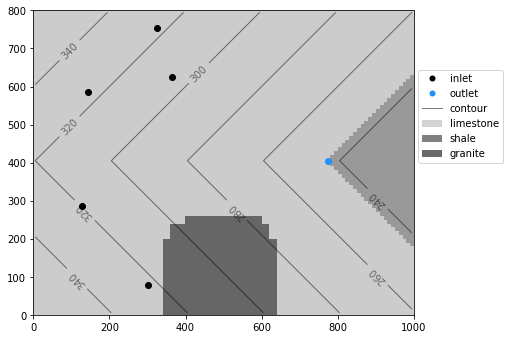

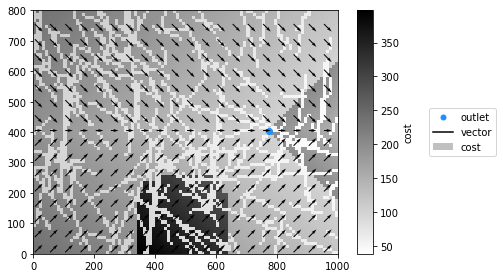

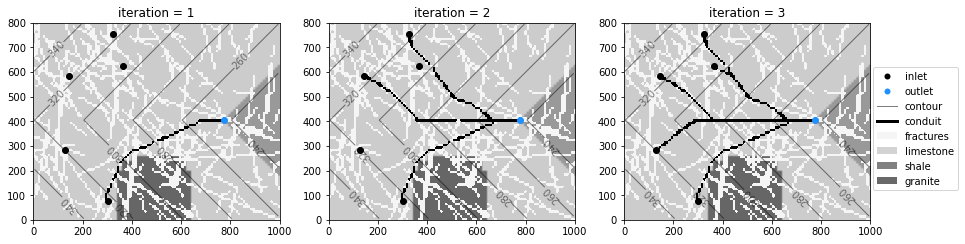

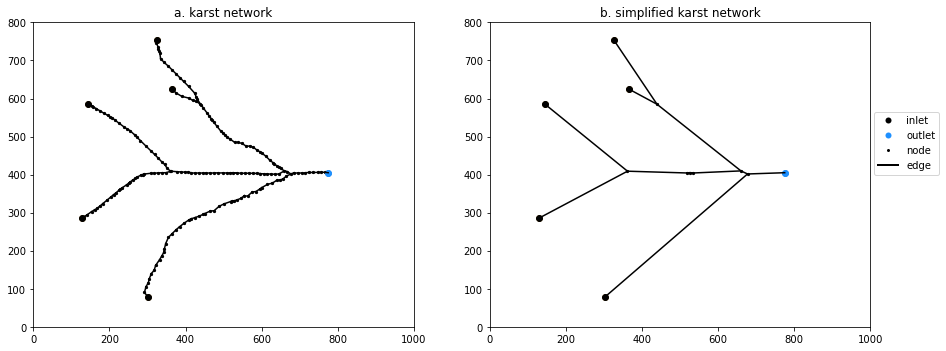

In [348]:
#Reload & update model with appropriate settings:
catchment = pk.SKS('inputs/valley1/settings.yaml')   #load settings file
catchment.set_fractures_mode('random')               #set fracture mode to randomly generate a fracture network
catchment.update_fractures()                         #when altering the model's geologic setting, need to update after making changes
catchment.set_inlets_importance([1,2,2])             #assign the first two inlets to the first outlet, and the remaining three inlets to the second outlet
catchment.set_algorithm('Riemann2')                  #set the fast-marching algorithm (Riemann is one version of an anisotropic algorith, 2 indicates 2D)
catchment.set_orientation_mode('surface')            #use the lower surface of the karst unit as the anisotropy field
catchment.update_orientation()                       #update model
catchment.compute_karst_network()                    #run the model to generate the karst network

#Inputs
###############
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
#ax.set_title('Inputs')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['surface']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.5])

#Anisotropy field
########################
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
#ax.set_title('Anisotropy field (lower surface of karst)')

im = plt.imshow(catchment.maps['alpha'][0], origin='lower', extent=catchment.grid.extent, cmap='gray_r')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')
skip=(slice(None,None,5),slice(None,None,5))
q = plt.quiver(catchment.grid.X[skip], catchment.grid.Y[skip], 
           -1*catchment.geology.data['orientationy']['data'][skip], -1*catchment.geology.data['orientationx']['data'][skip], scale=4)

plt.colorbar(im, aspect=15, shrink=0.3, label='cost')
legend = [matplotlib.lines.Line2D([0], [0], marker='o',  color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], marker=None, color='k', label='vector'),
          matplotlib.patches.Patch(facecolor='silver',   label='cost')]
plt.legend(handles=legend, loc=[1.3,0.4])

#Inlet iteration
###############
f = plt.figure(figsize=(15,15))
frac = catchment.geology.data['fractures']['data'].copy() #get a copy of the fractures array
frac[frac<1] = -1                                         #replace all non-fracture cells with an out of bounds value to make them transparent
cond = catchment.maps['karst'].copy()                     #get a copy of the karst array
cond = cond.astype('int')                                 #convert to integers to be able to manipulate
cond[cond<1] = -1                                         #replace all non-conduit cells with an out of bounds value to make them transparent

ax = f.add_subplot(131, aspect='equal')
ax.set_title('iteration = 1')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
plt.imshow(cond[0],                                   origin='lower', extent=catchment.grid.extent, cmap=cmap2,    vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['surface']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(132, aspect='equal')
ax.set_title('iteration = 2')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
plt.imshow(cond[1],                                   origin='lower', extent=catchment.grid.extent, cmap=cmap2,    vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['surface']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(133, aspect='equal')
ax.set_title('iteration = 3')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
plt.imshow(cond[2],                                   origin='lower', extent=catchment.grid.extent, cmap=cmap2,    vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['surface']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

#Outputs: network, simplified network, and table of statistics.
###############
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('a. karst network')

plt.imshow(catchment.maps['outlets'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=0)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=True, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(122, aspect='equal')
ax.set_title('b. simplified karst network')

plt.imshow(catchment.maps['outlets'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=0)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=True, labels=[], plot_nodes=True, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], marker='.', color='none', markerfacecolor='k', markeredgecolor='none', label='node'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=2, label='edge')]
plt.legend(handles=legend, loc=[1.01,0.5])

print('\n Network statistics:')
catchment.karst_simulations[0].stats

#### Isotropic vs. anisotropic ####
a. Isotropic fast marching results in conduits that travel uphill or cross through the syncline and climb up the other side to join existing conduits. <br>
b. Anisotropic fast marching results in conduits that converge towards the synclinal axis.

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


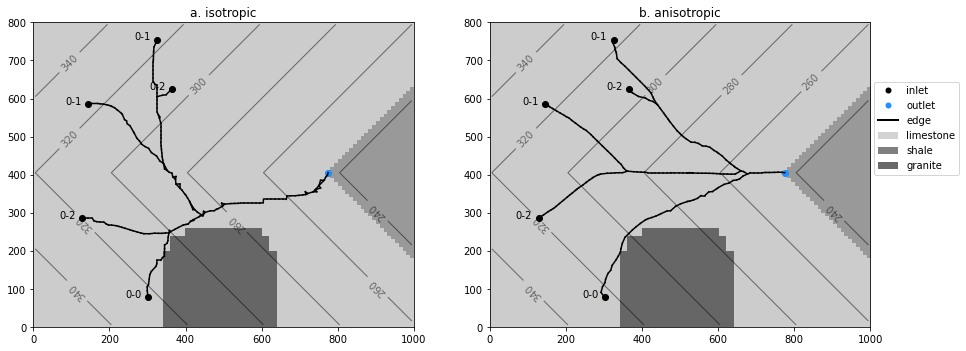

In [360]:
#Run the model with isotropic and anisotropic fast marching for comparison:
catchment = pk.SKS('inputs/valley1/settings.yaml')   #load settings file
catchment.set_fractures_mode('random')               #set fracture mode to randomly generate a fracture network
catchment.update_fractures()                         #when altering the model's geologic setting, need to update after making changes
catchment.set_inlets_importance([1,2,2])             #assign the first two inlets to the first outlet, and the remaining three inlets to the second outlet
catchment.set_orientation_mode('surface')            #use the lower surface of the karst unit as the anisotropy field
catchment.update_orientation()                       #update model
catchment.set_algorithm('Riemann2')                  #set the fast-marching algorithm (Riemann is one version of an anisotropic algorith, 2 indicates 2D)
catchment.compute_karst_network()                    #run the model to generate the karst network

catchment.set_algorithm('Isotropic2')                #set the fast-marching algorithm (isotropic, 2D)
catchment.compute_karst_network()                    #run the model again to generate another karst network

#Plot:
###########
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('a. isotropic')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['surface']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.imshow(catchment.maps['outlets'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=0)
catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(122, aspect='equal')
ax.set_title('b. anisotropic')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['surface']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.imshow(catchment.maps['outlets'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=0)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=2, label='edge'),
         matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.5])


#### Influence of different parameters ####

Influence of inlet/outlet assignment and iteration order on the final network structure:<br>
The number next to each inlet indicates which outlet it was assigned to. <br>
a. A network with loops created by intersecting conduits. <br>
b. Two disconnected networks. <br>
c. A misleadingly plausible-looking network that nevertheless involves a path crossing the syncline and climbing back up to spring 1 via an existing conduit from the first iteration.

In [349]:
#Inlet/outlet pairings:

#Load & set up model:
catchment = pk.SKS('inputs/valley1/settings.yaml')          #load model
catchment.set_algorithm('Riemann2')                         #set algorithm to 2D anisotropic
catchment.set_orientation_mode('surface')                   #choose lower contact of karst as anisotropy field
catchment.update_orientation()                
catchment.set_rand_seed(0)                                  #allow random variation from run to run
catchment.set_fractures_mode('random')                      #generate a random fracture network 
catchment.update_fractures()
catchment.set_outlets_data('inputs/valley1/outlets2D.txt')  #load a new outlet file with two outlets
catchment.set_inlets_shuffle(True)                          #shuffle inlet order
catchment.set_outlets_shuffle(True)                         #shuffle outlet order
catchment.set_outlets_importance([1,1])                     #assign each outlet to its own iteration
catchment.set_inlets_per_outlet([1,1])                      #assign an equal number of inlets to each outlet (if they don't divide evenly, pyKasso will get as close to even as possible)
catchment.set_inlets_importance([1])                        #assign all inlets for each outlet to a single iteration

#Iterate:
n = 3                                                       #set number of iterations
for i in range(n): 
    catchment.update_outlets()                              #update outlets - this will reshuffle them each run
    catchment.update_inlets()                               #update inlets - this will reshuffle them each run
    catchment.compute_karst_network()                       #run model

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


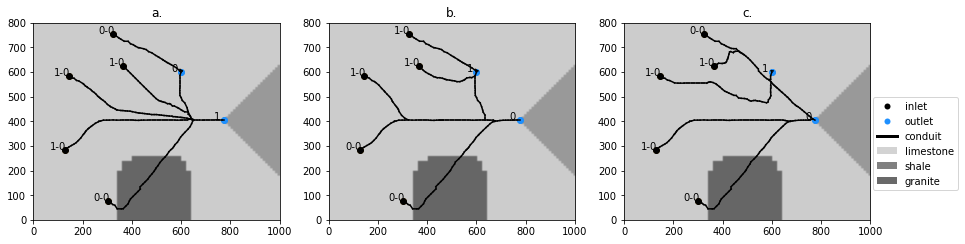

In [350]:
#Inlet/outlet pairings - plot
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(131, aspect='equal')
ax.set_title('a.')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=['inlets','outlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(132, aspect='equal')
ax.set_title('b.')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=['inlets','outlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(133, aspect='equal')
ax.set_title('c.')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[2], simplify=False, labels=['inlets', 'outlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

Influence of the travel cost through fractures on the final network structure:<br>
a. A fracture travel cost equal to or lower than the conduit travel cost results in conduits closely following fractures.<br>
b. A fracture travel cost between the conduit cost and the matrix cost results in conduits following fractures only when an existing conduit is not available to follow. <br>
c. A fracture travel cost higher than the matrix travel cost results in fractures avoiding conduits.

In [267]:
#Iterate over fracture cost:
catchment = pk.SKS('inputs/valley1/settings.yaml')
catchment.set_algorithm('Riemann2')
catchment.set_orientation_mode('surface')
catchment.update_orientation()
catchment.set_fractures_mode('random')
catchment.update_fractures()
catchment.set_inlets_importance([1,2,2])

catchment.set_cost_fractures(0.1) #same as conduits
catchment.compute_karst_network() 

catchment.set_cost_fractures(0.2) #between conduits and aquifer
catchment.compute_karst_network() 

catchment.set_cost_fractures(0.7) #higher than aquifer
catchment.compute_karst_network() 


CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


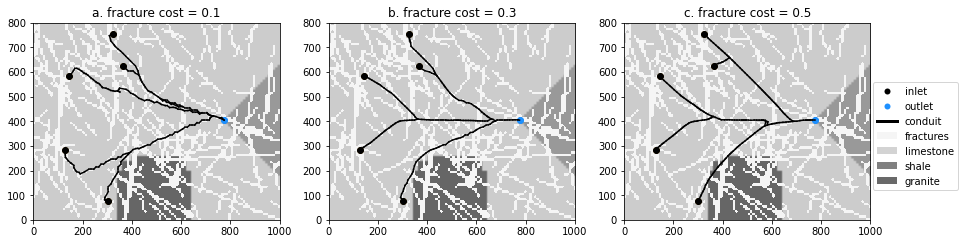

In [268]:
#Fracture cost
###############
f = plt.figure(figsize=(15,15))

frac = catchment.geology.data['fractures']['data'].copy() #get a copy of the fractures array
frac[frac<1] = -1                                         #replace all non-fracture cells with an out of bounds value to make them transparent

ax = f.add_subplot(131, aspect='equal')
ax.set_title('a. fracture cost = 0.1')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(132, aspect='equal')
ax.set_title('b. fracture cost = 0.3')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(133, aspect='equal')
ax.set_title('c. fracture cost = 0.5')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
catchment.show_network(ax=ax, data=catchment.karst_simulations[2], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

Influence of the travel cost through conduits on the final network structure. <br>
a. A very low conduit travel cost results in younger conduits traversing obstacles or moving upgradient to rejoin existing conduits. <br>
b. A conduit travel cost only slightly lower than the fracture or matrix cost results in younger conduits seeking older conduits when possible, forming a realistically-branching network. <br>
c. A conduit travel cost higher than the surrounding matrix results in conduits avoiding each other.

In [277]:
#Iterate over conduit cost:
catchment = pk.SKS('inputs/valley1/settings.yaml')
catchment.set_algorithm('Riemann2')
catchment.set_orientation_mode('surface')
catchment.update_orientation()
catchment.set_fractures_mode('random')
catchment.update_fractures()
catchment.set_inlets_importance([1,2,2])

catchment.set_cost_conduits(0.01) #very attractive
catchment.compute_karst_network() 

catchment.set_cost_conduits(0.1) #default
catchment.compute_karst_network() 

catchment.set_cost_conduits(0.6) #repellent
catchment.compute_karst_network() 

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


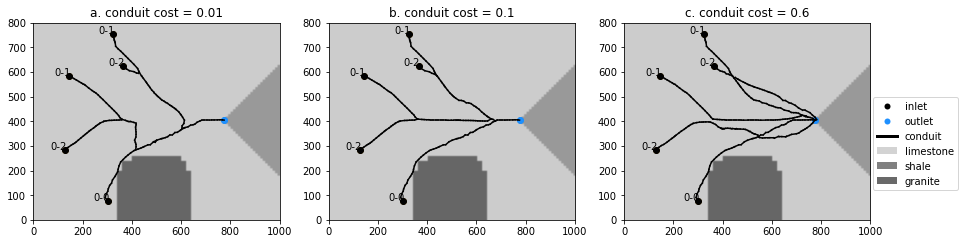

In [278]:
#Conduit cost
###############
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(131, aspect='equal')
ax.set_title('a. conduit cost = 0.01')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(132, aspect='equal')
ax.set_title('b. conduit cost = 0.1')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(133, aspect='equal')
ax.set_title('c. conduit cost = 0.6')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[2], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

Influence of the travel cost ratio on the final network structure. <br>
a. A cost ratio much lower than one results in conduits that follow the steepest gradient almost to the exclusion of all else, ignoring fractures or obstacles to do so. <br>
b. A cost ratio slightly lower than one results in conduits that prefer to follow the gradient, but will also avoid obstacles or follow fractures if they offer a less resistant path.<br>
c. A cost ratio greater than one results in conduits that follow contours, attempting to form perpendicular to the gradient.

In [279]:
#Iterate over cost ratio:
catchment = pk.SKS('inputs/valley1/settings.yaml')
catchment.set_algorithm('Riemann2')
catchment.set_orientation_mode('surface')
catchment.update_orientation()
catchment.set_fractures_mode('random')
catchment.update_fractures()
catchment.set_inlets_importance([1,2,2])

catchment.set_cost_ratio(0.2) #conduits follow gradient
catchment.compute_karst_network() 

catchment.set_cost_ratio(0.5) #default
catchment.compute_karst_network() 

catchment.set_cost_ratio(1.5) #conduits follow contours
catchment.compute_karst_network() 

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


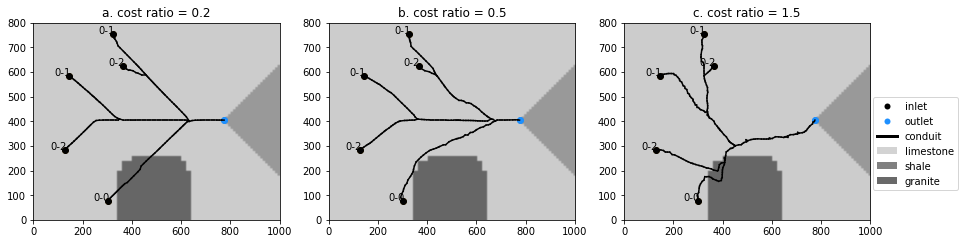

In [280]:
#Travel cost ratio
###############
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(131, aspect='equal')
ax.set_title('a. cost ratio = 0.2')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(132, aspect='equal')
ax.set_title('b. cost ratio = 0.5')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(133, aspect='equal')
ax.set_title('c. cost ratio = 1.5')
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
catchment.show_network(ax=ax, data=catchment.karst_simulations[2], simplify=False, labels=['inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

**Probability maps:** <br>
Generate many iterations with the same settings and plot together to see the range of possible networks.

In [351]:
#Iterate over many versions:
importlib.reload(pk)
catchment = pk.SKS('inputs/valley1/settings.yaml')
catchment.set_algorithm('Riemann2')
catchment.set_orientation_mode('surface')
catchment.update_orientation()
catchment.set_rand_seed(0)
catchment.set_fractures_mode('random')
#catchment.update_fractures()
catchment.set_inlets_importance([1,2,2])
#catchment.set_inlets_shuffle(True)

n = 10                                      #number of iterations to calculate (caution: more than 10 is slow)
for i in range(n):
    #catchment.update_inlets()
    catchment.update_fractures()
    catchment.compute_karst_network() 


CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
- initialize_costMap() - Warning : no geolog

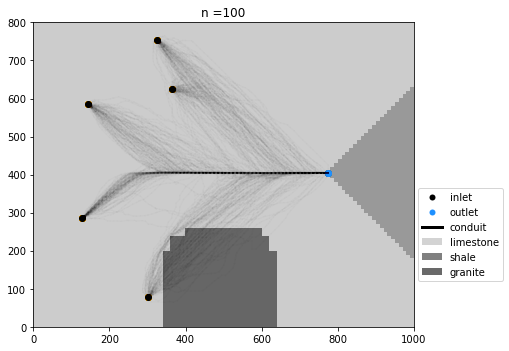

In [352]:
#Many iterations:
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121, aspect='equal')
ax.set_title('n ='+str(n))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
#plt.imshow(catchment._compute_average_paths(), origin='lower', extent=catchment.grid.extent, cmap='gray_r')
for i in range(n):
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

## One-valley cross-section ##
The system can also be modeled in cross-section, to simulate conduit development in the unsaturated zone. Generally, we expect mostly vertical conduits to form, descending from the surface inlets to the water table, then making their way to the outlet by the most direct path.<br>
We can create an anisotropy field that imposes a strong downward gradient in the unsaturated zone, while leaving the saturated zone unaffected

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


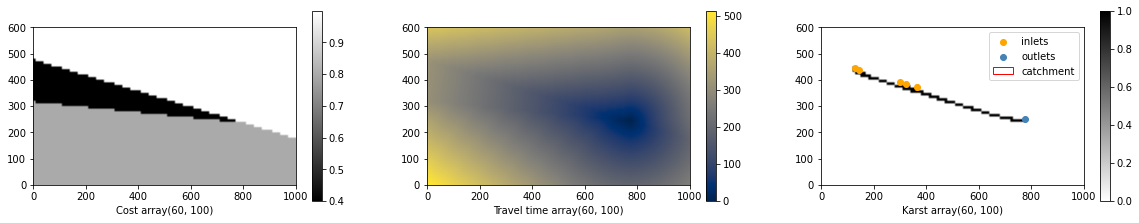


 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


In [283]:
importlib.reload(pk)

#Load model
catchment = pk.SKS('inputs/valley1/xsec/settings.yaml') 

#Run conduit network simulation & display results
catchment.compute_karst_network()
catchment.show()

#Compute anisotropic version
catchment.set_algorithm('Riemann2')
catchment.compute_karst_network()

C:\Users\Chloe\Anaconda3\envs\agd-hfm-pykasso\lib\site-packages\ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.
C:\Users\Chloe\Anaconda3\envs\agd-hfm-pykasso\lib\site-packages\ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.


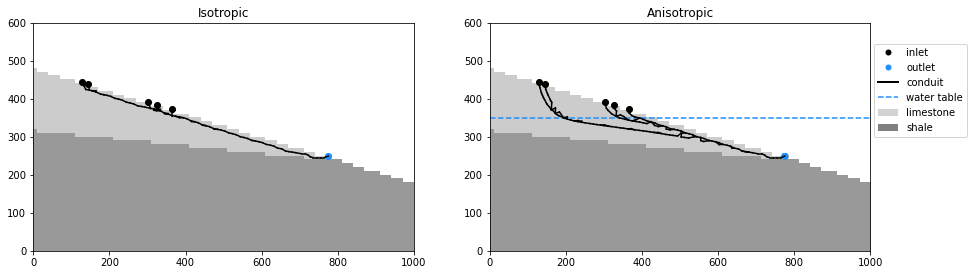

In [284]:
#Plot in format used in Paper 2:
importlib.reload(pk)

##############
cmap = matplotlib.colors.ListedColormap(['whitesmoke'])
cmap.set_under(color='w', alpha=0)
frac = catchment.geology.data['fractures']['data'].copy()
frac[frac<1] = -1

###############
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('Isotropic')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
#plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

###################
ax = f.add_subplot(122, aspect='equal')
ax.set_title('Anisotropic')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
#plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
plt.plot([catchment.grid.xmin, catchment.grid.xmax], [350,350], c='dodgerblue', ls='dashed')

catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue', linestyle='--')

###############
legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=2, alpha=1,   label='conduit'),
          matplotlib.lines.Line2D([0], [0], color='dodgerblue', ls='dashed', label='water table'),
          #matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale')]
plt.legend(handles=legend, loc=[1.01,0.5])

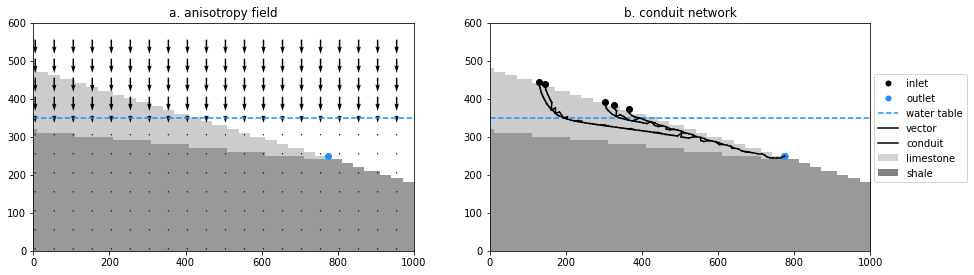

In [293]:
#Anisotropy field:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('a. anisotropy field')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.scatter(catchment.outlets[0,0], catchment.outlets[0,1], c='dodgerblue')
#plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.plot([catchment.grid.xmin, catchment.grid.xmax], [350,350], c='dodgerblue', ls='dashed')
skip=(slice(None,None,5),slice(None,None,5))
q = plt.quiver(catchment.grid.X[skip], catchment.grid.Y[skip], 
           -1*catchment.geology.data['orientationy']['data'][skip], -1*catchment.geology.data['orientationx']['data'][skip], scale=8)

###################
ax = f.add_subplot(122, aspect='equal')
ax.set_title('b. conduit network')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.plot([catchment.grid.xmin, catchment.grid.xmax], [350,350], c='dodgerblue', ls='dashed')
catchment.show_network(ax=ax, data=catchment.karst_simulations[1], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue', linestyle='--')

####################
legend = [matplotlib.lines.Line2D([0], [0], marker='o',  color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o',  color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='dodgerblue', ls='dashed', label='water table'),
          matplotlib.lines.Line2D([0], [0], marker=None, color='k', label='vector'),
          matplotlib.lines.Line2D([0], [0], marker=None, color='k', label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray', label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='shale')]

plt.legend(handles=legend, loc=[1.01,0.3])

### Gottesacker/Schwarzwassertal karst system ###
To demonstrate our approach on a real, complex example, we chose the extensively-studied Gottesacker/Schwarzwassertal karst system in the German/Austrian Alps (Goldscheider, 2005). This system consists of a series of plunging synclines and anticlines draining to the Schwarzwasser stream valley, which cuts roughly perpendicularly across the fold axes. The karst aquifer lies north of the valley in a limestone unit overlain by sandstone and underlain by non-karstifiable marl and older units (several other units are present, but for the purposes of conduit modeling, the geology has been simplified to only these four). Three major springs drain the system. South of the valley, unkarstifiable lithology prevents conduit development. 

#### Isotropic ####

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


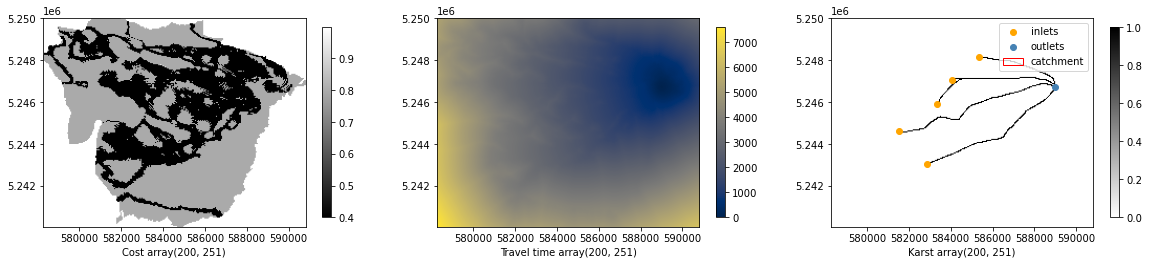

In [366]:
importlib.reload(pk)

catchment = pk.SKS('inputs/gottesacker/settings.yaml') #import settings and options from input folder
#catchment.show_catchment(data='topography')
#catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show()

#f,ax = plt.subplots(1,1, figsize=(10,10))
#ax.imshow(catchment.geology.data['topography']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', alpha=0.5)
#catchment.show_network(ax=ax)

#### Plot reference figure ####
Expected conduit network based on previous studies and tracer tests

In [630]:
#Define some new functions for plotting:
def show_base(data, ax=None, plot_nodes=True, labels=[], title=None, cmap=None, color='k', alpha=1, legend=True):
        """
        Show the base network as a graph with nodes and edges.
        Inputs: 
        data:   path & name prefix to node and edge data files (ex: folder/subfolder/yournamehere. Files MUST be named 'yournamehere_nodes.dat', and 'yournamehere_links.dat')
        ax:     axis to plot on
        labels: None or list of strings ['nodes','edges'], indicating which components to label
        title:  string, title of plot
        cmap:   string, colormap to use when plotting
        color:  string, single color to use when plotting (cannot have both cmap and color)
        alpha:  float, opacity to plot with (1=opaque, 0=transparent)
        legend: True/False, whether to display legend
        plot_nodes:   True/False, whether to display nodes
        """

        if ax == None:
            fig,ax = plt.subplots(figsize=(10,10))
            ax.set_aspect('equal')
            
        #Set up data for plotting:
        nodes  = pd.read_csv(data+'_nodes.dat', header=None, names=['y','x','z'], delim_whitespace=True) #import node data from ASCII file
        edges  = pd.read_csv(data+'_links.dat', header=None, names=['inNode','outNode'], delim_whitespace=True) #import edge data
        edges         = edges - 1               #convert from 1-based indexing to 0-based indexing
        fromX = nodes.x.loc[edges.inNode]       #calculate coordinates for link start and end points
        fromY = nodes.y.loc[edges.inNode]
        toX   = nodes.x.loc[edges.outNode]
        toY   = nodes.y.loc[edges.outNode]

        #Plot nodes and edges:
        if plot_nodes:
            n = ax.scatter(nodes.y,              nodes.x,                  c='k',         alpha=alpha, s=5)  #scatterplot nodes
        e = matplotlib.lines.Line2D([0],[0], c=color)                                                  #line artist for legend 
        for ind in edges.index:                                                               #loop over edge indices
            if cmap is not None:
                ax.plot((fromY.iloc[ind], toY.iloc[ind]), (fromX.iloc[ind], toX.iloc[ind]), c=plt.cm.get_cmap(cmap)(ind/len(edges)), alpha=alpha)  #plot each edge, moving along color gradient to show order
            elif color is not None:
                ax.plot((fromY.iloc[ind], toY.iloc[ind]), (fromX.iloc[ind], toX.iloc[ind]), c=color, alpha=alpha)  #plot each edge in same color
        
        #Add labels:
        if labels == None:
            pass
        else:
            if 'nodes' in labels:                                         #label node indices
                for ind in nodes.index:                                   #loop over node indices
                    ax.annotate(str(ind), xy=(nodes.y[ind]-10, nodes.x[ind]))  #annotate slightly to left of each node
            if 'edges' in labels:                                         
                for ind in edges.index:                                   
                    ax.annotate(str(ind), xy=(edges.y[ind]-10, edges.x[ind]))  #annotate slightly to left of each edge

        #Add legend & title:
        if legend:
            if plot_nodes:
                ax.legend([n,e],['nodes','edges'])
            else:
                ax.legend([e],['edges'])
        if title is not None:
            ax.set_title(title, fontsize=16)

        return None
    
def point2index(point, xmin,ymin,zmin, dx,dy,dz):
    '''Convert from x,y,z coordinates to i,j,k indices.'''
    x   = point[0]
    y   = point[1]
    z   = point[2]
    col = int((x - xmin) // dx)
    row = int((y - ymin) // dy)
    lay = int((z - zmin) // dz)
    
    return [col, row, lay]

Geology array: (200, 251, 52) 0 4


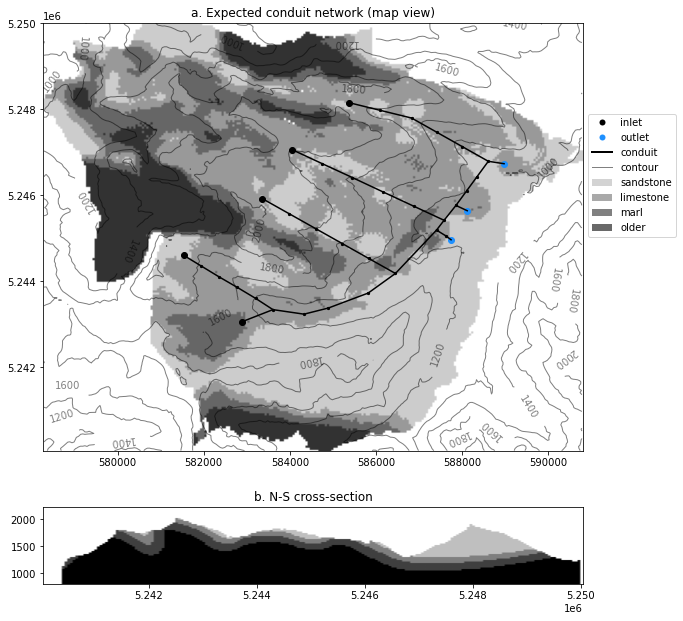

In [631]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(211, aspect='equal', position= [0, 0.6, 0.75, 0.75])  #[left, bottom, width, height]
ax.set_title('a. Expected conduit network (map view)')

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.imshow(catchment.maps['outlets'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=0)
show_base(data='inputs/gottesacker/base', ax=ax, legend=False)                                                 #plot base network
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

section = 585000.0                                                                        #choose a cross-section location
#plt.plot([section,section],[catchment.grid.ymin,catchment.grid.ymax], c='k', lw=1)        #uncomment to plot x-sec location

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',    lw=2, label='conduit'),
          matplotlib.lines.Line2D([0], [0], color='gray', lw=1, label='contour'),
         # matplotlib.lines.Line2D([0], [0], color='k',    lw=1, label='cross-section'),
          matplotlib.patches.Patch(facecolor='lightgray', label='sandstone'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='marl'),
          matplotlib.patches.Patch(facecolor='dimgray',   label='older')]
plt.legend(handles=legend, loc=[1.01,0.5])


#Cross-section
##############################
ax2 = f.add_subplot(212, aspect='equal', anchor='N', position= [0, 0.35, 0.75, 0.25])
plt.title('b. N-S cross-section')

#Get data:
zmin = 800;       znum = 52;   dz = 27.5;  zmax = zmin + znum*dz   #define system grid in the z direction
geo = pd.read_csv('inputs/gottesacker/geo200x251x52.gslib', skiprows=2)  #read in gslib file to pandas df without header rows
geo = geo.values
geo = np.reshape(geo,(catchment.grid.ynum,catchment.grid.xnum,znum),order='F') #reshape to xyz grid using Fortran ordering
print('Geology array:', geo.shape, geo.min(), geo.max())  
[ix,iy,iz] = point2index([section,0,0],  
                         catchment.grid.xmin, catchment.grid.ymin, zmin, 
                         catchment.grid.dx,   catchment.grid.dy,   dz)  #get index of cross-section location
plt.imshow(np.rot90(geo[:,ix,:],k=-1), origin='lower', extent=[catchment.grid.ymin,catchment.grid.ymax, zmin,zmax], cmap='gray_r')

#### Anisotropic ####
Simulate network with pyKasso

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


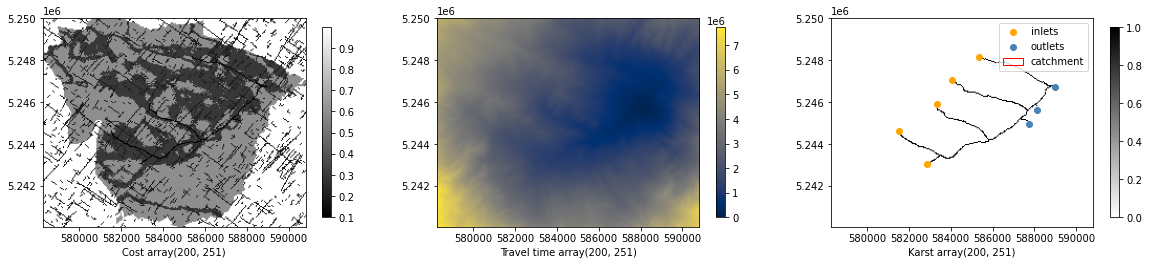

In [520]:
#Reload & calculate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/gottesacker/settings.yaml') #import settings and options from input folder
catchment.set_algorithm('Riemann2')                         #set algorithm to 2D anisotropic
catchment.set_fractures_mode('random')                      #generate a random fracture network 
catchment.set_rand_seed(0)                                  #get a different random choice each model run (set to 1 to keep same result each run)
catchment.update_fractures()                                #update model for changes to take effect
catchment.set_outlets_data('inputs/gottesacker/outlets2D.txt')  #load a new outlet file with all outlets
catchment.set_outlets_importance([1,1,1])                       #assign each outlet to its own iteration
catchment.set_inlets_per_outlet([2,2,1])                        #assign first two inlets to first outlet, next two inlets to second outlets, and last inlet to last outlet.
catchment.set_inlets_importance([1])                            #assign all inlets for each outlet to a single iteration
catchment.update_outlets()
catchment.update_inlets()
catchment.compute_karst_network()                               #run the model to calculate the karst network
catchment.show()

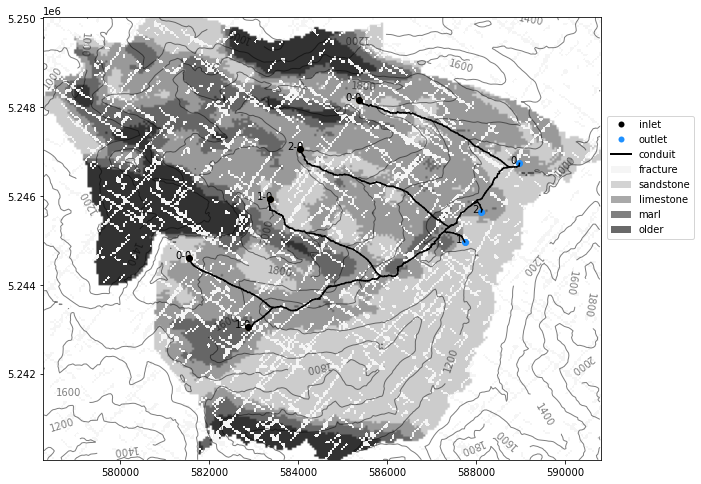

In [622]:
#Plot
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')
#ax.set_title('a. isotropic')

frac = catchment.geology.data['fractures']['data'].copy() #get a copy of the fractures array
frac[frac<1] = -1                                         #replace all non-fracture cells with an out of bounds value to make them transparent

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.imshow(catchment.maps['outlets'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=0)
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=['inlets', 'outlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')


legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=2, label='conduit'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fracture'),
          matplotlib.patches.Patch(facecolor='lightgray', label='sandstone'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='marl'),
          matplotlib.patches.Patch(facecolor='dimgray',   label='older')]
plt.legend(handles=legend, loc=[1.01,0.5])


#### Multiple iterations ###
Vary fracture network and/or inlet/outlet order to generate randomness

In [641]:
#Reload & calculate anisotropic network with multiple iterations:
catchment = pk.SKS('inputs/gottesacker/settings.yaml')          #import settings and options from input folder
catchment.set_algorithm('Riemann2')                             #set algorithm to 2D anisotropic
catchment.set_fractures_mode('random')                          #generate a random fracture network 
catchment.set_rand_seed(0)                                      #get a different random choice each model run (set to 1 to keep same result each run)
catchment.set_outlets_data('inputs/gottesacker/outlets2D.txt')  #load a new outlet file with all outlets
catchment.set_outlets_importance([1,1,1])                       #assign each outlet to its own iteration
catchment.set_inlets_per_outlet([2,2,1])                        #assign first two inlets to first outlet, next two inlets to second outlets, and last inlet to last outlet.
catchment.set_inlets_importance([1])                            #assign all inlets for each outlet to a single iteration
catchment.set_inlets_shuffle(True)                             #uncomment to shuffle inlet order
catchment.set_outlets_shuffle(True)                            #uncomment to shuffle outlet order
catchment.update_inlets()
catchment.update_outlets()

n = 10
for i in range(n):
    catchment.update_fractures()                                #uncomment to vary fractures each iteration
    catchment.update_outlets()                                 #ucomment to vary outlet order each iteration
    catchment.update_inlets()                                  #uncomment to vary inlet order each iteration
    catchment.compute_karst_network()                           #run the model to calculate the karst network

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean 

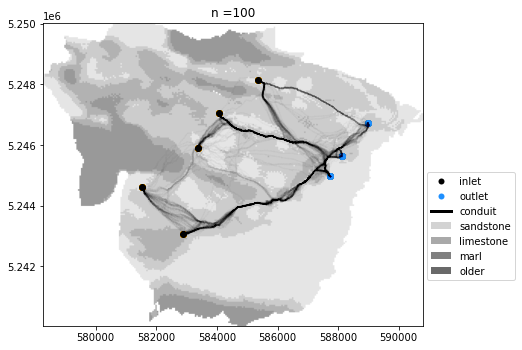

In [642]:
#Plot multiple iterations
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121, aspect='equal')
ax.set_title('n ='+str(n))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5, alpha=0.5)
#plt.imshow(catchment._compute_average_paths(), origin='lower', extent=catchment.grid.extent, cmap='gray_r')
for i in range(n):
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray', label='sandstone'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='marl'),
          matplotlib.patches.Patch(facecolor='dimgray',   label='older')]
plt.legend(handles=legend, loc=[1.01,0.15])

In [ ]:
#Plot in grid (optional)
run = False
if run == True:
    f,ax = plt.subplots(10,10,figsize=(15,15))
    for i in range(n):
        for x in range(10):
            for y in range(10):
                catchment.show_network(ax=ax[x,y], data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False)

#### Statistics ####

In [624]:
stats = pd.DataFrame(data=None, index=np.arange(n), columns=catchment.karst_simulations[0].stats.keys()) #make empty df
for i in range(n):                                                    #loop over iterations
    for key,value in catchment.karst_simulations[i].stats.items():    #loop over stats
        stats.loc[i,key] = value                                      #store in df
print('n =',n)
print('\nMean')
print(stats.mean())                                                         
print('\nStd. dev.')
print(stats.std())

n = 50

Mean
mean length                  784.369978
cv length                      1.558667
length entropy                 0.465110
tortuosity                     1.108114
orientation entropy            0.897289
aspl                           7.937386
cpd                            0.348356
mean degree                    2.302142
cv degree                      0.373089
correlation vertex degree     -0.417760
dtype: float64

Std. dev.
mean length                  226.544109
cv length                      0.237749
length entropy                 0.123974
tortuosity                     0.028247
orientation entropy            0.018458
aspl                           2.517656
cpd                            0.056789
mean degree                    0.095381
cv degree                      0.038331
correlation vertex degree      0.100823
dtype: float64


In [600]:
#Load expected network and get stats to compare:
base = kn.from_nodlink_dat('inputs/gottesacker/base')
base.characterize_graph()



 This network contains  1  connected components

Graph successfully created from file !

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


{'mean length': 1693.6092211105004,
 'cv length': 0.8190205473688449,
 'length entropy': 0.856087393862389,
 'tortuosity': 1.0043070925732775,
 'orientation entropy': 0.5141353494909473,
 'aspl': 3.3956043956043955,
 'cpd': 0.43392504930966463,
 'mean degree': 1.8571428571428572,
 'cv degree': 0.532938710021193,
 'correlation vertex degree': -0.44444444444444425}

#### Using contact surface ####
Note: this doesn't seem to lead to a much improved performance.

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


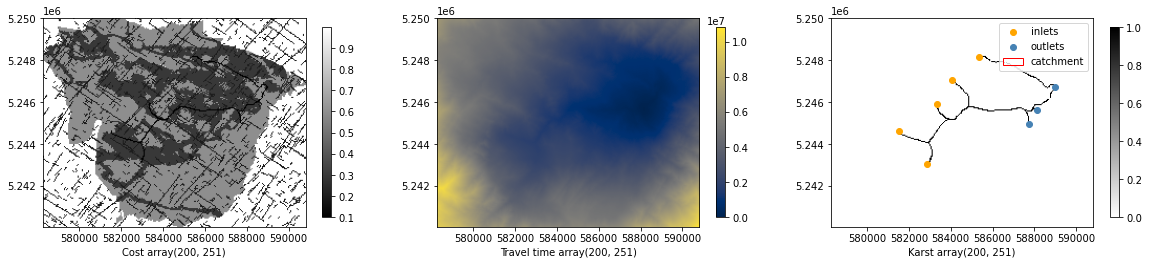


 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 T

In [570]:
#Reload & calculate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/gottesacker/settings.yaml') #import settings and options from input folder
catchment.set_algorithm('Riemann2')                         #set algorithm to 2D anisotropic
catchment.set_fractures_mode('random')                          #generate a random fracture network 
catchment.set_rand_seed(0)                                      #generate a new fracture network each model run
catchment.update_fractures()
catchment.set_orientation_mode('surface')                       #use the bottom surface of the limestone unit for the anisotropy field
catchment.update_orientation()
catchment.set_outlets_data('inputs/gottesacker/outlets2D.txt')  #load a new outlet file with all outlets
catchment.set_outlets_importance([1,1,1])                       #assign each outlet to its own iteration
catchment.set_inlets_per_outlet([2,2,1])                        #assign first two inlets to first outlet, next two inlets to second outlets, and last inlet to last outlet.
catchment.set_inlets_importance([1])                            #assign all inlets for each outlet to a single iteration
catchment.update_outlets()
catchment.update_inlets()
catchment.compute_karst_network()
catchment.show()

#Iterate
n = 10
for i in range(n):
    catchment.update_fractures()                                #vary fractures each iteration
    #catchment.update_outlets()
    #catchment.update_inlets()
    catchment.compute_karst_network()                            #run the model to calculate the karst network

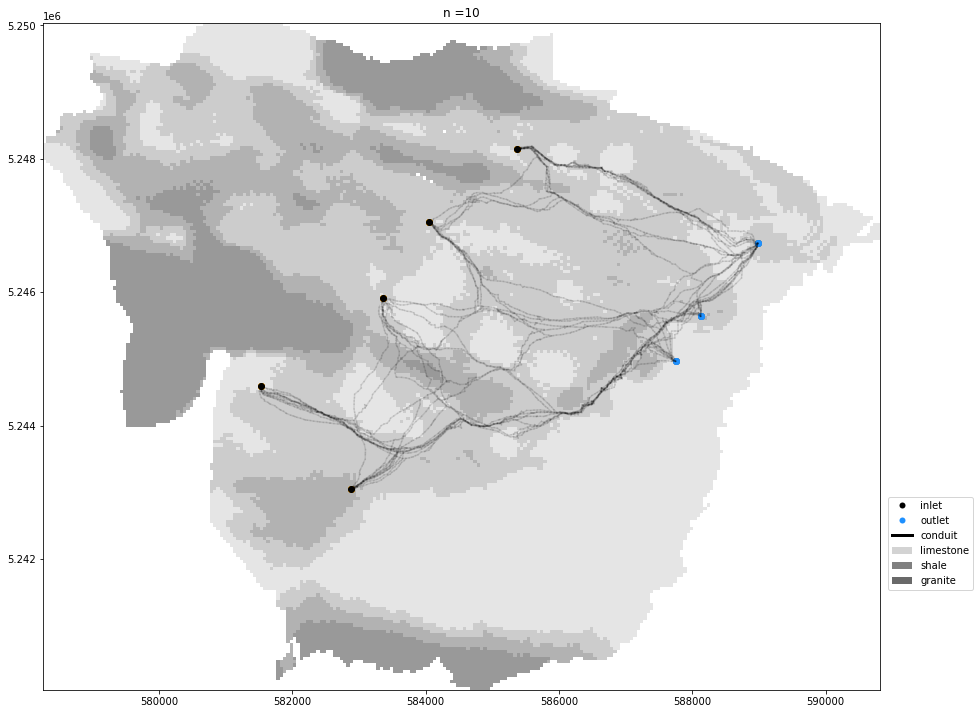

In [572]:
#Plot probability map:
f = plt.figure(figsize=(10,10))

ax = f.add_subplot(121, aspect='equal')
ax.set_title('n ='+str(n))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5, alpha=0.5)
#plt.imshow(catchment._compute_average_paths(), origin='lower', extent=catchment.grid.extent, cmap='gray_r')
for i in range(n):
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray', label='sandstone'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='marl'),
          matplotlib.patches.Patch(facecolor='dimgray',   label='older')]
plt.legend(handles=legend, loc=[1.01,0.15])

##### Plot anisotropy field ####

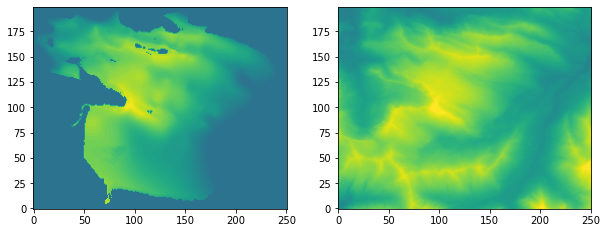

In [562]:
#Compare contact surface with land surface
f = plt.figure(figsize=(10,10))
f.add_subplot(121, aspect='equal')
plt.imshow(catchment.geology.data['surface']['data'],    origin='lower', cmap='gray_r', vmin=0,vmax=2100)
f.add_subplot(122, aspect='equal')
plt.imshow(catchment.geology.data['topography']['data'], origin='lower', cmap='gray_r', vmin=0,vmax=2100)


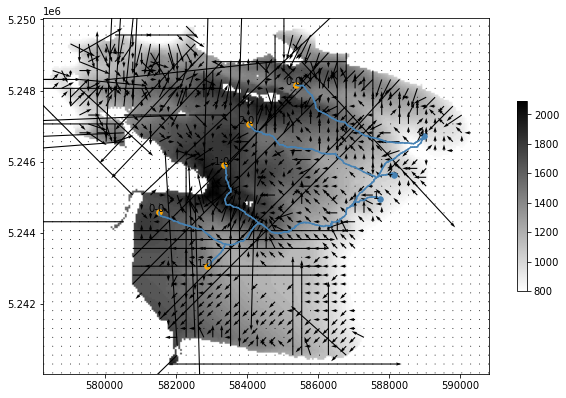

In [571]:
#Plot vector field
f,ax = plt.subplots(1,1, figsize=(10,10))
m = catchment.geology.data['topography']['data']
im = ax.imshow(m, origin='lower', extent=catchment.grid.extent, cmap='gray_r')
plt.colorbar(im, ax=ax, shrink=0.35)
skip=(slice(None,None,5),slice(None,None,5))
plt.quiver(catchment.grid.X[skip], catchment.grid.Y[skip], 
           catchment.geology.data['orientationy']['data'][skip], catchment.geology.data['orientationx']['data'][skip], scale=20)
catchment.show_network(ax=ax, color='steelblue', legend=False, plot_nodes=False)

#### Compare to SKS ####

In [ ]:
#In development: pull data from SKS runs on Gottesacker to compare to pyKasso
run = False
if run == True:
    data_path    =  r'C:\Users\Chloe\Documents\GitHub\gottesacker_v1\data'             #path to data folder
    SKS          = pd.read_csv(os.path.join(data_path,'data.csv'),  index_col=[0,1,2]) #import dic of all run data from latest ensemble
    allIDs       = pd.read_csv(os.path.join(data_path, 'IDs.csv'))                     #import dic of all model IDs from latest ensemble
    sksIDs       = list(allIDs.sksIDs[ allIDs.sksIDs.notna()])                         #extract SKS IDs
    n = 100
    #Create empty dfs to store node and link data
    #nodesAll = pd.DataFrame(data=None, index=['simple','complex'], columns=sksIDs, dtype='object') 
    #linksAll = pd.DataFrame(data=None, index=['simple','complex'], columns=sksIDs, dtype='object')

    f,ax = plt.subplots(10,10,figsize=(10,10))

    for i in range(100):
        for x in range(10):
            for y in range(10):        #loop over all SKS runs for first round
                sksRunID = sksIDs[i]                #get SKS ID for current run
                show_base(data=os.path.join(data_path,sksRunID+'SKS'), ax=ax[x,y], legend=False, plot_nodes=False)                                                 #plot base network
                ax[x,y].get_yaxis().set_visible(False)                       #hide axis ticks & labels
                ax[x,y].get_xaxis().set_visible(False)

# END OF WORKING CODE #

## Betteraz
In progress


CAUTION: You are using the development version of this package.


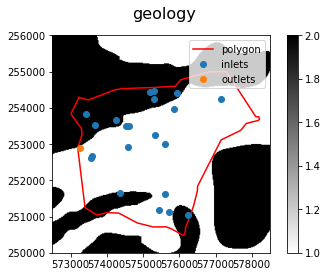

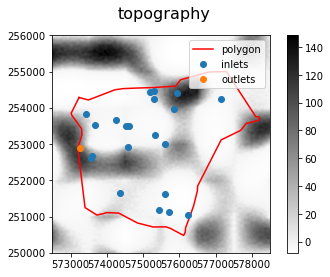

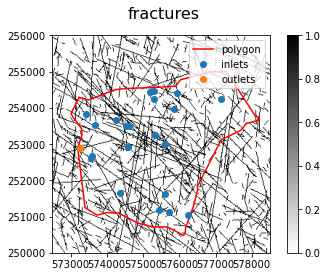

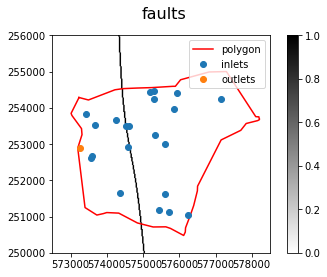


 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


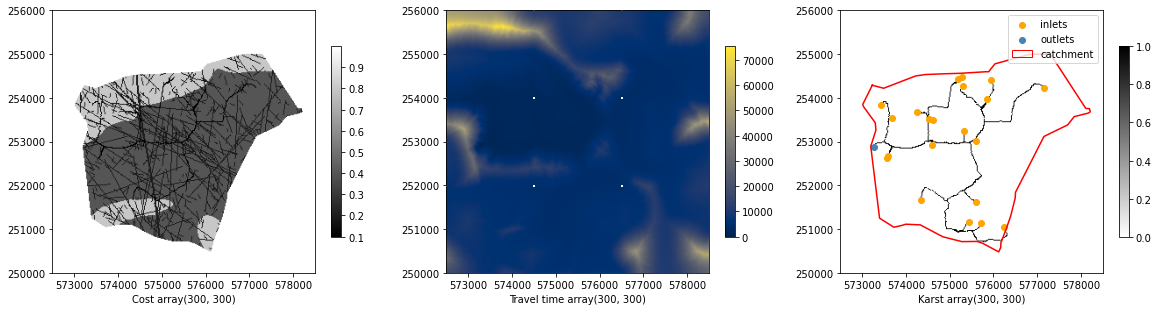

In [520]:
importlib.reload(pk)

catchment = pk.SKS('inputs/betteraz/betteraz_cas_1.yaml')
#catchment = pk.SKS() #test default
catchment.show_catchment(data='geology')
catchment.show_catchment(data='topography')
catchment.show_catchment(data='fractures')
catchment.show_catchment(data='faults')
catchment.compute_karst_network()
catchment.show()

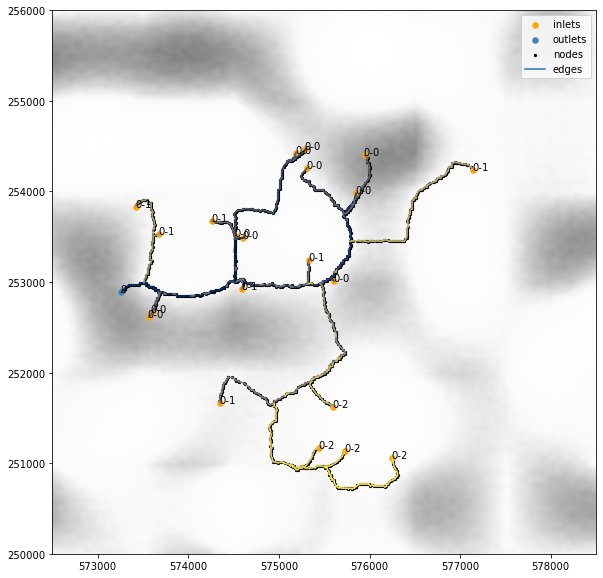

In [521]:
f,ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(catchment.geology.data['topography']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', alpha=0.5)
catchment.show_network(ax=ax)